# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os, cv2, json, random, itertools, rasterio, math, time, psutil, warnings

# np.random.seed(0)
# tf.random.set_seed(0)

from tqdm import tqdm
from IPython.display import SVG
from tensorflow.keras.utils import plot_model, model_to_dot, to_categorical, Sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import *

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (Add, Input, Conv2D, Dropout, Activation, BatchNormalization, MaxPooling2D, ZeroPadding2D, AveragePooling2D, Flatten, Dense, Concatenate)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, Callback, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import *
from tensorflow.keras.regularizers import *

from tensorflow.keras.preprocessing.image import img_to_array, load_img
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
warnings.filterwarnings("ignore")

# Running TensorBoard

# Utility Functions:

In [2]:
def show_final_history(history):
    
    plt.style.use("ggplot")
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')
    
    ax[0].plot(history.history['loss'], 'r-', label='Training Loss')
    ax[0].plot(history.history['val_loss'], 'g-', label='Validation Loss')
    ax[1].plot(history.history['categorical_accuracy'], 'r-', label='Training Accuracy')
    ax[1].plot(history.history['val_categorical_accuracy'], 'g-', label='Validation Accuracy')
    
    ax[0].legend(loc='upper right')
    ax[1].legend(loc='lower right')
    
    plt.show();
    pass

In [3]:
def plot_learning_rate(loss_history):
    
    plt.style.use("ggplot")
    
    plt.plot(np.arange(0,len(loss_history.lr)), loss_history.lr)
    plt.show();
    pass

In [4]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar();
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f'
    thresh = cm.max()/2.0
    
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j,i, format(cm[i,j], fmt),
                horizontalalignment = 'center',
                color = "white" if cm[i,j] > thresh else "black")
        pass
    
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.grid(False);
    pass

In [5]:
with open("../input/eurosat-dataset/EuroSATallBands/label_map.json","r") as f:
    class_names_encoded = json.load(f)
    pass

class_names = list(class_names_encoded.keys())
num_classes = len(class_names)
class_names_encoded

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

In [6]:
bands = {'1':1,'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'8a':9,'9':10,'10':11,'11':12,'12':13}

## Defining Normalisation

In [7]:
def Normalise(arr_band):
    
    return StandardScaler().fit_transform(arr_band)

## Data Generator

In [8]:
basePath = "../input/eurosat-dataset/EuroSATallBands"

def data_generator(csv_file, num_classes, batch_size = 10, target_size = 64):
    i = 0
    classes = set()
    df = pd.read_csv(csv_file)
    num_samples = df.shape[0]
    
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_samples_idx = df.index[offset:offset+batch_size]

            X, y = [], []

            for i in batch_samples_idx:
                img_name = df.loc[i,'Filename']
                label = df.loc[i,'Label']

                src = rasterio.open(os.path.join(basePath,img_name))

                arr_3, arr_4, arr_8 = src.read(bands['3']).astype(np.float32), src.read(bands['4']).astype(np.float32), src.read(bands['8']).astype(np.float32)
                arr_6, arr_7 = src.read(bands['6']).astype(np.float32), src.read(bands['7']).astype(np.float32)
                arr_11 = src.read(bands['11']).astype(np.float32)

                arr_3 = Normalise(arr_3)
                arr_4 = Normalise(arr_4)
                arr_6, arr_7 = Normalise(arr_6), Normalise(arr_7)
                arr_8 = Normalise(arr_8)
                arr_11 = Normalise(arr_11)

                bands_10_20 = np.dstack((arr_3, arr_4, arr_6, arr_7, arr_8, arr_11))

                X.append(bands_10_20)
                y.append(label)
                pass

            X = np.array(X)
            y = np.array(y)
            y = to_categorical(y, num_classes = num_classes)
            
            yield X, y
            pass
        pass
    pass


In [9]:
train_generator = data_generator(csv_file = "../input/eurosat-dataset/EuroSATallBands/train.csv", num_classes = 10, batch_size = 10)
val_generator = data_generator(csv_file = "../input/eurosat-dataset/EuroSATallBands/validation.csv", num_classes = 10, batch_size = 10)

In [10]:
train_df = pd.read_csv("../input/eurosat-dataset/EuroSATallBands/train.csv")
train_labels = train_df.loc[:,'Label']
train_labels = np.array(train_labels)

num_train_samples = train_labels.shape[0]

val_df = pd.read_csv("../input/eurosat-dataset/EuroSATallBands/validation.csv")
val_labels = val_df.loc[:,'Label']
val_labels = np.array(val_labels)

num_val_samples = val_labels.shape[0]

num_train_samples, num_val_samples

(19317, 5519)

# Defining the Model

In [11]:
def spectral_block(X,filters,stage,s=1):
    
    squeeze_base_name = 'squeeze_' + str(stage) + '_branch'
    bn_base_name = 'bn_' + str(stage) + "_branch"
    
    F1,F2,F3 = filters
    
    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(s,s), padding='same', name=squeeze_base_name+'a')(X)
    
    X_11 = Conv2D(filters=F2, kernel_size=(1,1), strides=(s,s), padding='same', name=squeeze_base_name+'b')(X)
    X_33 = Conv2D(filters=F3, kernel_size=(3,3), strides=(s,s), padding='same', name=squeeze_base_name+'c')(X)
    
    X = Concatenate(name="concatenate_"+str(stage))([X_11, X_33])
    X = BatchNormalization(name=bn_base_name)(X)
    
    X = Activation("relu", name="spectral"+str(stage))(X)
    
    return X
    pass

In [12]:
def SpectrumNet(input_shape, classes):
    
    X_input = Input(input_shape, name="input")
    
    X = Conv2D(96, (1,1), strides=(2,2), name='conv1', padding="same")(X_input)
    
    X = spectral_block(X, [16,96,32], 2)
    X = spectral_block(X, [16,96,32], 3)
    X = spectral_block(X, [32,192,64], 4)
    
    X = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="same", name="maxpool4")(X)
    
    X = spectral_block(X, [32,192,64], 5)
    X = spectral_block(X, [48, 288, 96], 6)
    X = spectral_block(X, [48, 288, 96], 7)
    X = spectral_block(X, [64, 384, 128], 8)
    
    X = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="same", name="maxpool8")(X)
    
    X = spectral_block(X, [64,384,128], 9)
    
    X = Conv2D(10, kernel_size=(1,1), strides=(1,1), name="conv10", padding='same')(X)
    X = BatchNormalization(name="conv10_batchnormalisation")(X)
    X = Activation("relu", name="conv10_activation")(X)
    
    X = AveragePooling2D(pool_size=(8,8), strides=(1,1), name="avgpool10")(X)
    
    X = Flatten(name="flatten10")(X)
    
#     X = Dense(16, name="dense_1")(X)
#     X = Activation("relu",name="dense_relu_1")(X)
    
#     X = Dense(256, name="dense_2")(X)
#     X = Activation("relu",name="dense_relu_2")(X)
    
#     X = Dense(512,name="dense_3")(X)
#     X = Activation("relu", name="dense_relu_3")(X)
    
#     X = Dense(classes,activation="softmax",name="fc"+str(classes))(X)

    X = Activation("softmax", name="output")(X)
    
    model = Model(inputs=X_input, outputs=X, name="SpectrumNet")
    
    return model
    pass

In [15]:
model = SpectrumNet(input_shape = (64,64,6), classes=num_classes)

In [16]:
model.summary()

Model: "SpectrumNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 64, 64, 6)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 96)   672         input[0][0]                      
__________________________________________________________________________________________________
squeeze_2_brancha (Conv2D)      (None, 32, 32, 16)   1552        conv1[0][0]                      
__________________________________________________________________________________________________
squeeze_2_branchb (Conv2D)      (None, 32, 32, 96)   1632        squeeze_2_brancha[0][0]          
________________________________________________________________________________________

In [18]:
checkpoint = ModelCheckpoint("6bands_weights_v5-5_SC.h5", monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
logs = TensorBoard("6bands-logs-SC", histogram_freq=1)

In [19]:
def step_decay(epoch):
   initial_lrate = 0.001
   drop = 0.10
   epochs_drop = 30.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate

In [20]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
       self.losses = []
       self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
       self.losses.append(logs.get('loss'))
       self.lr.append(step_decay(len(self.losses)))

In [21]:
loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay)

In [22]:
train_labels_encoded = to_categorical(train_labels,num_classes=10)

classTotals = train_labels_encoded.sum(axis=0)
classWeight = {}

for i in range(len(classTotals)):
    classWeight[i] = classTotals.max()/classTotals[i]
    pass

classWeight

{0: 1.1985714,
 1: 1.1985714,
 2: 1.1985714,
 3: 1.4382857,
 4: 1.4382857,
 5: 1.7978572,
 6: 1.4382857,
 7: 1.1985714,
 8: 1.4382857,
 9: 1.0}

In [23]:
# opt = Adam(lr=1e-3)
# model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

In [24]:
opt = SGD(lr=1e-3, momentum=0.9, nesterov=True)
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['categorical_accuracy'])

# Training Model

In [25]:
epochs = 100
batchSize = 100

history = model.fit(train_generator,
                   steps_per_epoch = num_train_samples//batchSize,
                   epochs = epochs,
                   verbose = 1,
                   validation_data = val_generator,
                   validation_steps = num_val_samples//batchSize,
                   callbacks = [checkpoint, lrate, loss_history],
                   class_weight = classWeight
                   )

Epoch 1/100
193/193 [==============================] - ETA: 0s - loss: 2.4699 - categorical_accuracy: 0.4710
Epoch 00001: val_categorical_accuracy improved from -inf to 0.15455, saving model to 6bands_weights_v5-5_SC.h5
193/193 [==============================] - 56s 290ms/step - loss: 2.4699 - categorical_accuracy: 0.4710 - val_loss: 2.4807 - val_categorical_accuracy: 0.1545
Epoch 2/100
193/193 [==============================] - ETA: 0s - loss: 1.9993 - categorical_accuracy: 0.6212
Epoch 00002: val_categorical_accuracy improved from 0.15455 to 0.56000, saving model to 6bands_weights_v5-5_SC.h5
193/193 [==============================] - 55s 284ms/step - loss: 1.9993 - categorical_accuracy: 0.6212 - val_loss: 1.4211 - val_categorical_accuracy: 0.5600
Epoch 3/100
193/193 [==============================] - ETA: 0s - loss: 1.7007 - categorical_accuracy: 0.6782
Epoch 00003: val_categorical_accuracy improved from 0.56000 to 0.76182, saving model to 6bands_weights_v5-5_SC.h5
193/193 [=========

193/193 [==============================] - ETA: 0s - loss: 0.7372 - categorical_accuracy: 0.8332
Epoch 00024: val_categorical_accuracy did not improve from 0.90364
193/193 [==============================] - 44s 230ms/step - loss: 0.7372 - categorical_accuracy: 0.8332 - val_loss: 0.6975 - val_categorical_accuracy: 0.7818
Epoch 25/100
193/193 [==============================] - ETA: 0s - loss: 0.7018 - categorical_accuracy: 0.8492
Epoch 00025: val_categorical_accuracy did not improve from 0.90364
193/193 [==============================] - 45s 232ms/step - loss: 0.7018 - categorical_accuracy: 0.8492 - val_loss: 0.7021 - val_categorical_accuracy: 0.7636
Epoch 26/100
193/193 [==============================] - ETA: 0s - loss: 0.7327 - categorical_accuracy: 0.8425
Epoch 00026: val_categorical_accuracy did not improve from 0.90364
193/193 [==============================] - 45s 233ms/step - loss: 0.7327 - categorical_accuracy: 0.8425 - val_loss: 0.3967 - val_categorical_accuracy: 0.8655
Epoch 27

Epoch 48/100
193/193 [==============================] - ETA: 0s - loss: 0.5370 - categorical_accuracy: 0.8984
Epoch 00048: val_categorical_accuracy did not improve from 0.95818
193/193 [==============================] - 45s 232ms/step - loss: 0.5370 - categorical_accuracy: 0.8984 - val_loss: 0.1967 - val_categorical_accuracy: 0.9582
Epoch 49/100
193/193 [==============================] - ETA: 0s - loss: 0.4877 - categorical_accuracy: 0.9150
Epoch 00049: val_categorical_accuracy did not improve from 0.95818
193/193 [==============================] - 45s 234ms/step - loss: 0.4877 - categorical_accuracy: 0.9150 - val_loss: 0.1930 - val_categorical_accuracy: 0.9509
Epoch 50/100
193/193 [==============================] - ETA: 0s - loss: 0.5136 - categorical_accuracy: 0.9021
Epoch 00050: val_categorical_accuracy did not improve from 0.95818
193/193 [==============================] - 45s 232ms/step - loss: 0.5136 - categorical_accuracy: 0.9021 - val_loss: 0.2130 - val_categorical_accuracy: 0.

193/193 [==============================] - ETA: 0s - loss: 0.5329 - categorical_accuracy: 0.8902
Epoch 00072: val_categorical_accuracy did not improve from 0.97455
193/193 [==============================] - 45s 235ms/step - loss: 0.5329 - categorical_accuracy: 0.8902 - val_loss: 0.2461 - val_categorical_accuracy: 0.9182
Epoch 73/100
193/193 [==============================] - ETA: 0s - loss: 0.5145 - categorical_accuracy: 0.9083
Epoch 00073: val_categorical_accuracy did not improve from 0.97455
193/193 [==============================] - 45s 234ms/step - loss: 0.5145 - categorical_accuracy: 0.9083 - val_loss: 0.1699 - val_categorical_accuracy: 0.9527
Epoch 74/100
193/193 [==============================] - ETA: 0s - loss: 0.4892 - categorical_accuracy: 0.9078
Epoch 00074: val_categorical_accuracy did not improve from 0.97455
193/193 [==============================] - 45s 235ms/step - loss: 0.4892 - categorical_accuracy: 0.9078 - val_loss: 0.2416 - val_categorical_accuracy: 0.9255
Epoch 75

Epoch 97/100
193/193 [==============================] - ETA: 0s - loss: 0.5159 - categorical_accuracy: 0.9041
Epoch 00097: val_categorical_accuracy did not improve from 0.97455
193/193 [==============================] - 48s 251ms/step - loss: 0.5159 - categorical_accuracy: 0.9041 - val_loss: 0.1486 - val_categorical_accuracy: 0.9655
Epoch 98/100
193/193 [==============================] - ETA: 0s - loss: 0.4873 - categorical_accuracy: 0.9171
Epoch 00098: val_categorical_accuracy did not improve from 0.97455
193/193 [==============================] - 45s 235ms/step - loss: 0.4873 - categorical_accuracy: 0.9171 - val_loss: 0.1958 - val_categorical_accuracy: 0.9436
Epoch 99/100
193/193 [==============================] - ETA: 0s - loss: 0.4378 - categorical_accuracy: 0.9223
Epoch 00099: val_categorical_accuracy did not improve from 0.97455
193/193 [==============================] - 46s 237ms/step - loss: 0.4378 - categorical_accuracy: 0.9223 - val_loss: 0.1951 - val_categorical_accuracy: 0.

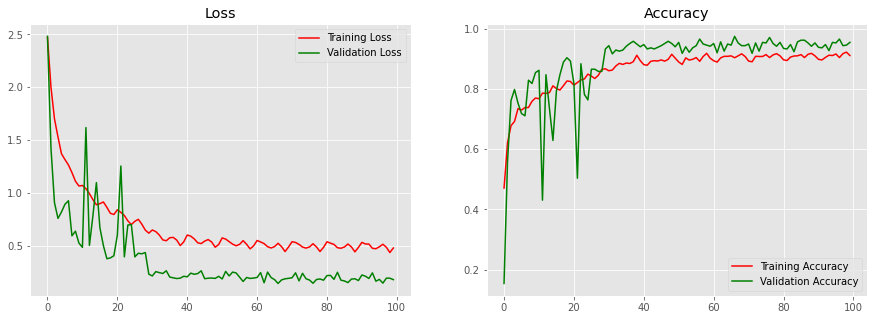

In [26]:
show_final_history(history)

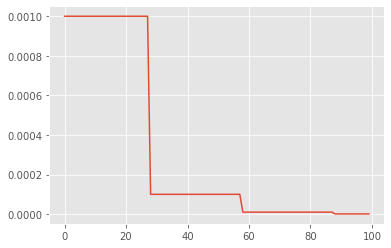

In [27]:
plot_learning_rate(loss_history)

In [28]:
def obtain_tif_images(csv_file):
    
    df = pd.read_csv(csv_file)
    num_samples = df.shape[0]
    
    X, y = [], []
    
    for i in tqdm(range(num_samples)):
        
        img_name = df.loc[i,'Filename']
        label = df.loc[i,'Label']

        src = rasterio.open(os.path.join(basePath,img_name))
        arr_3, arr_4, arr_8 = src.read(bands['3']), src.read(bands['4']), src.read(bands['8']) 
        arr_6, arr_7 = src.read(bands['6']), src.read(bands['7'])
        arr_11 = src.read(bands['11'])

        arr_3 = np.array(arr_3, dtype=np.float32)
        arr_4 = np.array(arr_4, dtype=np.float32)
        arr_6, arr_7 = np.array(arr_6, dtype=np.float32), np.array(arr_7, dtype=np.float32)
        arr_8 = np.array(arr_8, dtype=np.float32)
        arr_11 = np.array(arr_11, dtype=np.float32)

        arr_3 = Normalise(arr_3)
        arr_4 = Normalise(arr_4)
        arr_6, arr_7 = Normalise(arr_6), Normalise(arr_7)
        arr_8 = Normalise(arr_8)
        arr_11 = Normalise(arr_11)

        bands_10_20 = np.dstack((arr_3, arr_4, arr_6, arr_7, arr_8, arr_11))

        X.append(bands_10_20)
        y.append(label)
        
        pass
    
    X = np.array(X)
    y = np.array(y)
    
    return X,y
    pass

# Validation Phase

In [29]:
test_tifs, test_labels = obtain_tif_images(csv_file="../input/eurosat-dataset/EuroSATallBands/test.csv")

test_labels_encoded = to_categorical(test_labels, num_classes = len(class_names))

test_tifs.shape, test_labels.shape, test_labels_encoded.shape

100%|██████████| 2759/2759 [00:55<00:00, 50.04it/s]


((2759, 64, 64, 6), (2759,), (2759, 10))

In [30]:
test_pred = model.predict(test_tifs)
test_pred = np.argmax(test_pred, axis=1)
test_pred.shape

(2759,)

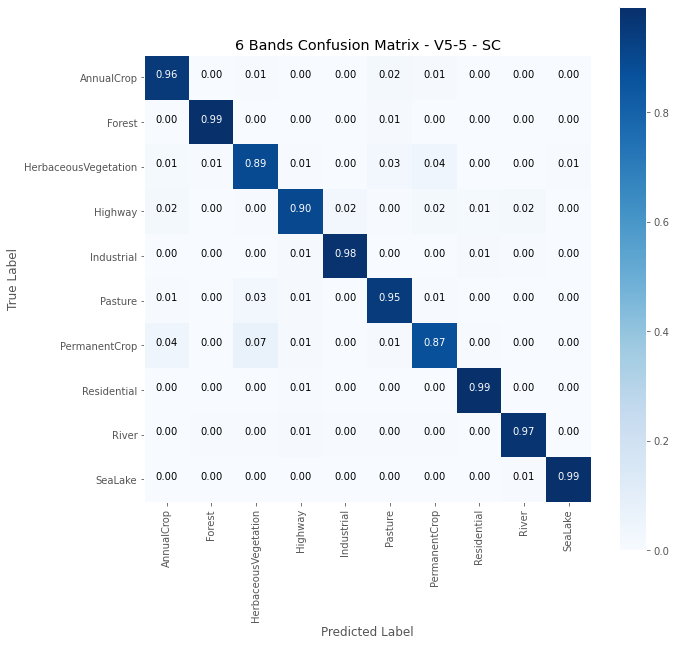

In [31]:
cnf_mat = confusion_matrix(test_labels, test_pred)

plot_confusion_matrix(cnf_mat, classes=class_names, title="6 Bands Confusion Matrix - V5-5 - SC")
plt.grid(False);

In [32]:
for f1,class_name in zip(f1_score(test_labels, test_pred, average=None), class_names):
    print("Class name: {}, F1 score: {:.3f}".format(class_name, f1))
    pass

Class name: AnnualCrop, F1 score: 0.944
Class name: Forest, F1 score: 0.988
Class name: HerbaceousVegetation, F1 score: 0.897
Class name: Highway, F1 score: 0.922
Class name: Industrial, F1 score: 0.974
Class name: Pasture, F1 score: 0.925
Class name: PermanentCrop, F1 score: 0.890
Class name: Residential, F1 score: 0.987
Class name: River, F1 score: 0.970
Class name: SeaLake, F1 score: 0.990


In [33]:
model.save("6bands_v5-5_SC.h5")

In [ ]:
model_test = load_model("./6bands_v5-5_SC.h5")

model_test.summary()

In [ ]:
model_test.load_weights("./6bands_weights_v5-5_SC.h5")

In [ ]:
test_pred_2 = model_test.predict(test_tifs)
test_pred_2 = np.argmax(test_pred_2, axis=1)
test_pred_2.shape

In [ ]:
for f1,class_name in zip(f1_score(test_labels, test_pred_2, average=None), class_names):
    print("Class name: {}, F1 score: {:.3f}".format(class_name, f1))
    pass

In [ ]:
cnf_mat = confusion_matrix(test_labels, test_pred_2)

plot_confusion_matrix(cnf_mat, classes=class_names, title="Testing Model V5-5 CNF-MAT")
plt.grid(False)

In [ ]:
val_tifs, val_labels = obtain_tif_images(csv_file="../input/eurosat-dataset/EuroSATallBands/validation.csv")

val_labels_encoded = to_categorical(val_labels, num_classes = len(class_names))

val_tifs.shape, val_labels.shape, val_labels_encoded.shape

In [ ]:
val_pred = model_test.predict(val_tifs)
val_pred = np.argmax(val_pred, axis=1)
val_pred.shape

In [ ]:
for f1,class_name in zip(f1_score(val_labels, val_pred, average=None), class_names):
    print("Class name: {}, F1 score: {:.3f}".format(class_name, f1))
    pass

In [ ]:
cnf_mat = confusion_matrix(val_labels, val_pred)

plot_confusion_matrix(cnf_mat, classes=class_names,title="Validation Model V5-5 CNF-MAT")
plt.grid(False)